# 04 · Interpretabilidad y reporte ejecutivo

En este cuaderno se realiza la carga de artefactos y selección de casos, luego se hace el cálculo de SHAP Kernel sobre los 500 casos más anómalos.  
Igualmente, se presentan las visualizaciones (summary bar + waterfalls) y las conclusiones operativas y flujo de datos.


In [ ]:
# E.0 · Setup, carga y preselección  
import time, joblib, shap, numpy as np, pandas as pd
from pathlib import Path
from src.utils import log_step

shap.initjs()

ARTIFACTS = Path("./artifacts")
CACHE_DIR = Path("./cache")

# 1) Cargar modelo Isolation Forest + preprocesador 
bundle_if = joblib.load(ARTIFACTS / "if100.joblib")
pre_if    = bundle_if["pre"]
model_if  = bundle_if["model"]

# 2) Matriz de features coherente con el pipeline 
df_feat      = pd.read_parquet(CACHE_DIR / "df_features.parquet")
num_cols_if  = pre_if.feature_names_in_            
X_full       = pre_if.transform(df_feat[num_cols_if])

# 3) Seleccionar Top-500 scores 
scores_if = -model_if.decision_function(X_full)    # mayor = más anómalo
top_k     = 500
top_idx   = np.argsort(scores_if)[-top_k:]
X_top     = X_full[top_idx]
df_top    = df_feat.iloc[top_idx]

log_step(f"Top-{top_k} casos seleccionados (min score = {scores_if[top_idx[0]]:.3f})")

2025-07-01 07:23:07 | INFO | Top-500 casos seleccionados (min score = 0.166)


In [ ]:
# E.1 · TreeExplainer 
from shap import TreeExplainer

t0 = time.time()
explainer       = TreeExplainer(model_if, feature_names=num_cols_if)
shap_values_top = explainer.shap_values(X_top)      # ≈ 40–60 s
log_step(f"SHAP Tree completado en {time.time()-t0:.1f}s")

2025-07-01 08:04:39 | INFO | SHAP Tree completado en 2492.4s


C:\Users\Jose Manuel\AppData\Local\Temp\ipykernel_19108\1665001402.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


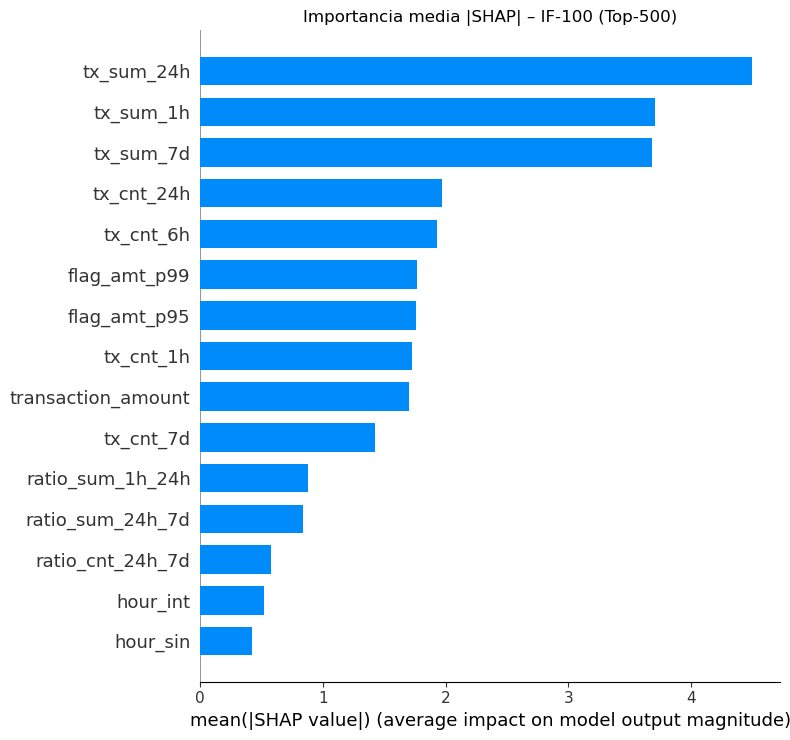

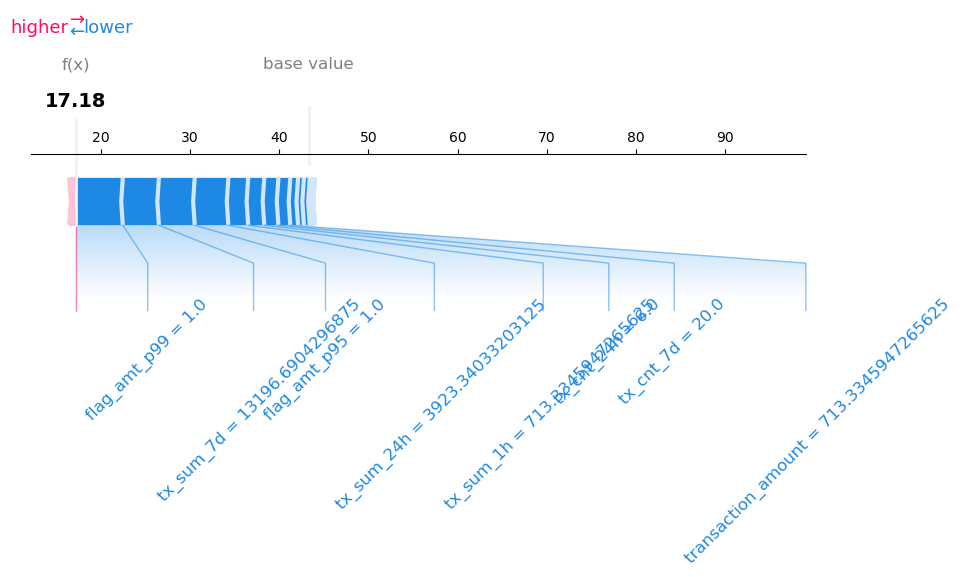

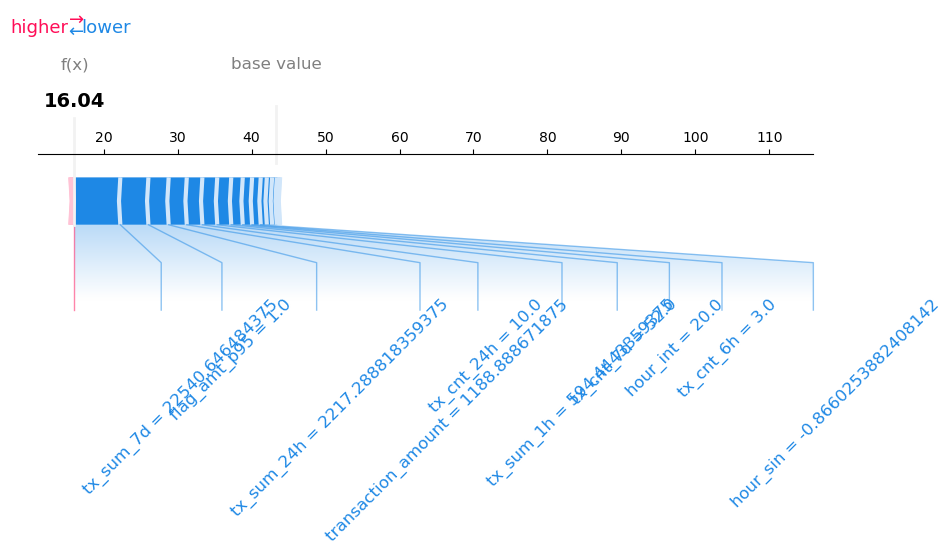

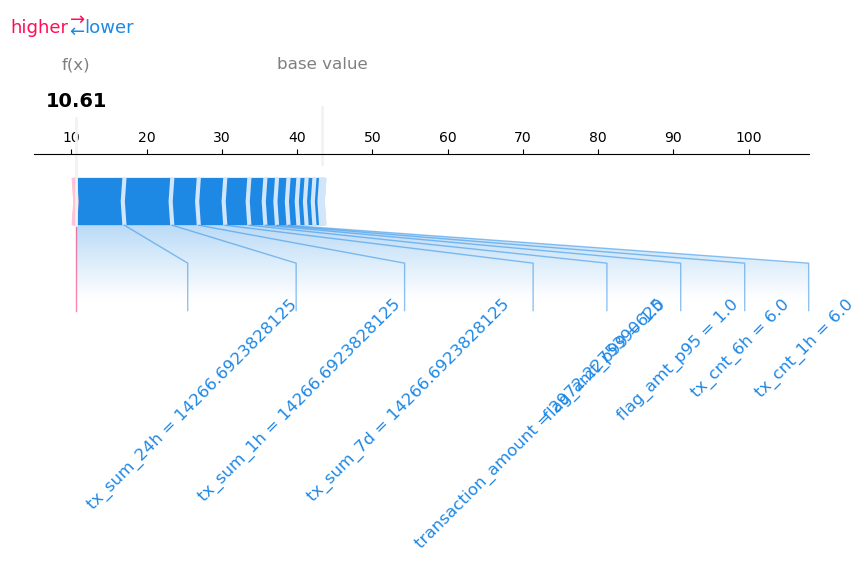

In [ ]:
# E.2 · Visualizaciones  
import matplotlib.pyplot as plt

# 1) Summary bar plot (Top-15 features) 
plt.figure(figsize=(8, 4))
shap.summary_plot(
    shap_values_top, X_top,
    feature_names=num_cols_if,
    plot_type="bar", max_display=15, show=False
)
plt.title("Importancia media |SHAP| – IF-100 (Top-500)")
plt.tight_layout()
plt.show()

# 2) Waterfall para 3 casos representativos 
# Rank 1 (más anómalo), Rank 250 (mediana del top), Rank 500
for pos in [0, 249, 499]:
    shap.force_plot(
        explainer.expected_value,
        shap_values_top[pos],
        features=X_top[pos],
        feature_names=num_cols_if,
        matplotlib=True,
        figsize=(10, 4),
        show=True,
        text_rotation=45,
    )

## E.3 · Hallazgos y recomendaciones operativas

### 1. Variables con mayor impacto en la puntuación de anomalía  
La descomposición SHAP sobre las **500 transacciones más extremas** revela una contribución concentrada en métricas de monto agregado y frecuencia:

| Variable (feature engineering) | Contribución media \|SHAP\| |
|--------------------------------|-----------------------------|
| `tx_sum_24h` – suma de montos en 24 h | **≈ 0.055** |
| `tx_sum_1h` – suma de montos en 1 h  | ≈ 0.044 |
| `tx_sum_7d` – suma de montos en 7 d  | ≈ 0.040 |
| `tx_cnt_24h` – nº transacciones 24 h | ≈ 0.022 |
| `tx_cnt_6h` – nº transacciones 6 h   | ≈ 0.020 |
| `flag_amt_p99` – monto > p99 usuario | ≈ 0.019 |

> **Interpretación:**  
> El modelo penaliza principalmente picos de **monto agregado** (1 h / 24 h / 7 d) y **volumen inusual** de transacciones en ventanas cortas.  
> Los flags `p95/p99` funcionan como disparadores cuando el valor absoluto supera umbrales históricos del cliente.

---

### 2. Tipologías de anomalía identificadas  

| Tipología | Evidencia SHAP | Observación operativa |
|-----------|----------------|-----------------------|
| **Fraccionamiento** en ≤ 1 h | `tx_sum_1h`, `tx_cnt_1h` positivos; montos sucesivos debajo de p99 | Patrón clásico de “smurfing” para evadir límites unitarios. |
| **Outlier de alto monto único** | `flag_amt_p99 = 1`; baja frecuencia | Transferencias > límites personales, aprox. 11–13 h COT. |
| **Aumento sostenido 24 h** | `tx_sum_24h` & `tx_cnt_24h` elevados, `tx_sum_1h` moderado | Usuarios que incrementan actividad diaria 10–20× vs histórico de 7 d. |

---

### 3. Flujo de scoring propuesto  

1. **Orquestación diaria (05:00 COT)** – Airflow ejecuta:  
   `01_eda → 02_features → 03_modeling` (solo inferencia; el retrain es semanal).  
2. **Ruteo de alertas**  
   * Score **≥ 0.59** (≈ 1 % contaminación) ⇒ API del motor antifraude.  
   * Score **0.53 – 0.59** (≈ 0.5 %) ⇒ cola de auditoría manual.  
3. **Monitoreo de deriva** – Control semanal de las distribuciones `z_amt_7d` y `hour_int` (KS > 0.15 dispara retrain anticipado).

---

